In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, Dropout, LSTM
from tensorflow.python.keras import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import OrdinalEncoder
from pandas import DataFrame
from pandas import concat
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score
import seaborn as sns

In [2]:
months = ['January', 'February', 'March', 'April', 'October', 'November', 'December']

In [3]:
acc = list()

In [4]:
f1 = list()

In [5]:
err = list()

In [6]:
house_data = pd.read_csv("../preprocessed_data/std_test_data_ebfd64742c95ab9f71f8ac8a810624464782d17d.csv")

In [7]:
house_data.head()

,index,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,Month,DayOfWeek,HourofDay,Day,T_ctrl,T_stp_heat,Humidity,auxHeat1,fan,Thermostat_Temperature,T_out,RH_out
0,0,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,-0.449119,-0.792779,-0.354029,0,0,-0.440369,0.113647,1.575996
1,1,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,-0.449119,-0.792779,-0.354029,0,0,-0.440369,0.113647,1.575996
2,2,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,-0.449119,-0.792779,-0.354029,0,0,-0.440369,0.113647,1.575996
3,3,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,-0.449119,-0.792779,-0.354029,0,0,-0.440369,0.113647,1.575996
4,4,0.0,1.0,0.0,1.0,0.755303,0.484974,1,1,0,1,-0.449119,-0.792779,-0.354029,0,0,-0.440369,0.113647,1.575996


In [8]:
house_data.Month.value_counts()

5     8917
12    8889
1     8695
4     8611
11    8609
3     8233
6     7775
10    5859
2     5212
Name: Month, dtype: int64

In [9]:
def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
cumulative_df = pd.DataFrame({"T_ctrl": [], 
                              "T_stp_heat": [], 
                              "T_out" : [], 
                              "RH_out" : [],
                              "auxHeat1" : []})

# January

In [11]:
working_df = house_data[house_data.Month == 1]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(6951, 34) (6951, 21) (1738, 34) (1738, 21)


In [12]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
696/696 [==============================] - 2s 4ms/step - loss: 0.6820 - accuracy: 0.8852 - val_loss: 0.4123 - val_accuracy: 0.9287
Epoch 2/20
696/696 [==============================] - 2s 3ms/step - loss: 0.3559 - accuracy: 0.9334 - val_loss: 0.3383 - val_accuracy: 0.9367
Epoch 3/20
696/696 [==============================] - 2s 3ms/step - loss: 0.3223 - accuracy: 0.9383 - val_loss: 0.3257 - val_accuracy: 0.9402
Epoch 4/20
696/696 [==============================] - 2s 3ms/step - loss: 0.3112 - accuracy: 0.9386 - val_loss: 0.3153 - val_accuracy: 0.9384
Epoch 5/20
696/696 [==============================] - 2s 3ms/step - loss: 0.3007 - accuracy: 0.9394 - val_loss: 0.3084 - val_accuracy: 0.9396
Epoch 6/20
696/696 [==============================] - 2s 3ms/step - loss: 0.2975 - accuracy: 0.9403 - val_loss: 0.3249 - val_accuracy: 0.9356
Epoch 7/20
696/696 [==============================] - 2s 3ms/step - loss: 0.2880 - accuracy: 0.9417 - val_loss: 0.3007 - val_accuracy: 0.9396
Epoch 

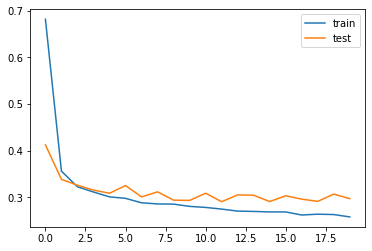

In [13]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

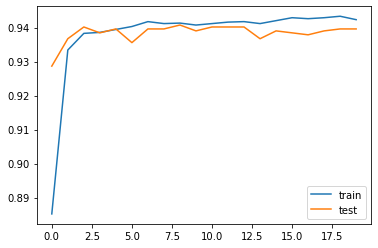

In [14]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [15]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

110295
106950
Error Percentage in predicted values is : 3.032775737794098 %


In [16]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# February

In [17]:
working_df = house_data[house_data.Month == 2]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(11120, 34) (11120, 21) (2781, 34) (2781, 21)


In [18]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
1112/1112 [==============================] - 3s 3ms/step - loss: 0.5567 - accuracy: 0.9047 - val_loss: 0.3283 - val_accuracy: 0.9385
Epoch 2/20
1112/1112 [==============================] - 3s 3ms/step - loss: 0.3290 - accuracy: 0.9356 - val_loss: 0.3336 - val_accuracy: 0.9399
Epoch 3/20
1112/1112 [==============================] - 3s 3ms/step - loss: 0.3152 - accuracy: 0.9372 - val_loss: 0.2995 - val_accuracy: 0.9396
Epoch 4/20
1112/1112 [==============================] - 3s 3ms/step - loss: 0.3068 - accuracy: 0.9382 - val_loss: 0.2928 - val_accuracy: 0.9389
Epoch 5/20
1112/1112 [==============================] - 3s 3ms/step - loss: 0.3030 - accuracy: 0.9388 - val_loss: 0.3221 - val_accuracy: 0.9407
Epoch 6/20
1112/1112 [==============================] - 3s 3ms/step - loss: 0.2983 - accuracy: 0.9383 - val_loss: 0.2826 - val_accuracy: 0.9421
Epoch 7/20
1112/1112 [==============================] - 3s 3ms/step - loss: 0.2945 - accuracy: 0.9379 - val_loss: 0.2794 - val_accuracy:

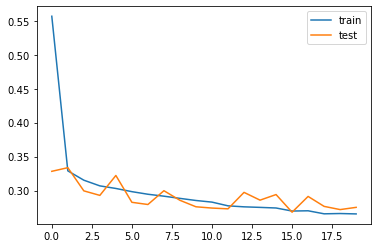

In [19]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

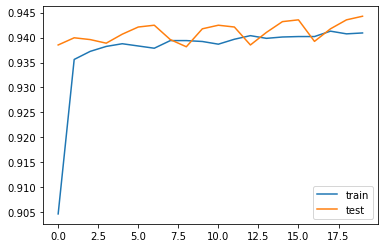

In [20]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [21]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

176415
175485
Error Percentage in predicted values is : 0.5271660573080521 %


In [22]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# March

In [23]:
working_df = house_data[house_data.Month == 3]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(17707, 34) (17707, 21) (4427, 34) (4427, 21)


In [24]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
1771/1771 [==============================] - 6s 3ms/step - loss: 0.4762 - accuracy: 0.9187 - val_loss: 0.3017 - val_accuracy: 0.9408
Epoch 2/20
1771/1771 [==============================] - 6s 3ms/step - loss: 0.3115 - accuracy: 0.9384 - val_loss: 0.3000 - val_accuracy: 0.9410
Epoch 3/20
1771/1771 [==============================] - 6s 3ms/step - loss: 0.2984 - accuracy: 0.9390 - val_loss: 0.2738 - val_accuracy: 0.9435
Epoch 4/20
1771/1771 [==============================] - 6s 3ms/step - loss: 0.2900 - accuracy: 0.9396 - val_loss: 0.2696 - val_accuracy: 0.9442
Epoch 5/20
1771/1771 [==============================] - 6s 3ms/step - loss: 0.2840 - accuracy: 0.9402 - val_loss: 0.2682 - val_accuracy: 0.9449
Epoch 6/20
1771/1771 [==============================] - 6s 3ms/step - loss: 0.2793 - accuracy: 0.9406 - val_loss: 0.2606 - val_accuracy: 0.9456
Epoch 7/20
1771/1771 [==============================] - 6s 3ms/step - loss: 0.2756 - accuracy: 0.9420 - val_loss: 0.2557 - val_accuracy:

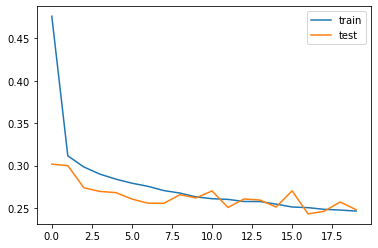

In [25]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

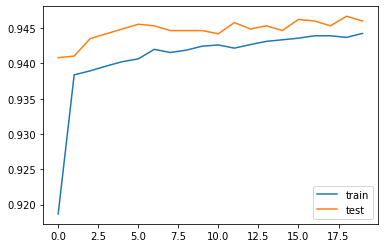

In [26]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [27]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

253530
242475
Error Percentage in predicted values is : 4.360430718258194 %


In [28]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# April

In [29]:
working_df = house_data[house_data.Month == 4]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(24596, 34) (24596, 21) (6149, 34) (6149, 21)


In [30]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
2460/2460 [==============================] - 8s 3ms/step - loss: 0.4582 - accuracy: 0.9208 - val_loss: 0.3253 - val_accuracy: 0.9354
Epoch 2/20
2460/2460 [==============================] - 8s 3ms/step - loss: 0.3193 - accuracy: 0.9367 - val_loss: 0.3076 - val_accuracy: 0.9384
Epoch 3/20
2460/2460 [==============================] - 8s 3ms/step - loss: 0.3054 - accuracy: 0.9385 - val_loss: 0.2922 - val_accuracy: 0.9402
Epoch 4/20
2460/2460 [==============================] - 8s 3ms/step - loss: 0.2948 - accuracy: 0.9396 - val_loss: 0.2882 - val_accuracy: 0.9411
Epoch 5/20
2460/2460 [==============================] - 8s 3ms/step - loss: 0.2900 - accuracy: 0.9399 - val_loss: 0.2752 - val_accuracy: 0.9429
Epoch 6/20
2460/2460 [==============================] - 8s 3ms/step - loss: 0.2836 - accuracy: 0.9406 - val_loss: 0.2747 - val_accuracy: 0.9428
Epoch 7/20
2460/2460 [==============================] - 8s 3ms/step - loss: 0.2798 - accuracy: 0.9408 - val_loss: 0.2798 - val_accuracy:

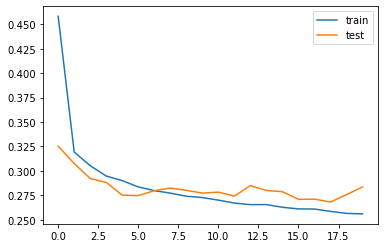

In [31]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

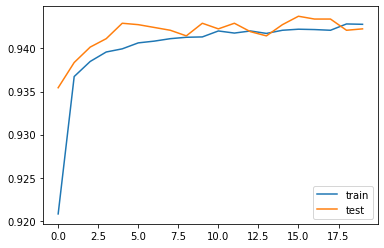

In [32]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [33]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

301590
300630
Error Percentage in predicted values is : 0.3183129414105242 %


In [34]:
f1_score(y_test, y_predicted, average = 'weighted')
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))
acc.append(max(history.history['accuracy']))

# October

In [35]:
working_df = house_data[house_data.Month == 10]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(29283, 34) (29283, 21) (7321, 34) (7321, 21)


In [36]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
2929/2929 [==============================] - 10s 3ms/step - loss: 0.4055 - accuracy: 0.9299 - val_loss: 0.3350 - val_accuracy: 0.9313
Epoch 2/20
2929/2929 [==============================] - 9s 3ms/step - loss: 0.2950 - accuracy: 0.9415 - val_loss: 0.2947 - val_accuracy: 0.9419
Epoch 3/20
2929/2929 [==============================] - 9s 3ms/step - loss: 0.2829 - accuracy: 0.9431 - val_loss: 0.2886 - val_accuracy: 0.9411
Epoch 4/20
2929/2929 [==============================] - 9s 3ms/step - loss: 0.2761 - accuracy: 0.9432 - val_loss: 0.3008 - val_accuracy: 0.9404
Epoch 5/20
2929/2929 [==============================] - 9s 3ms/step - loss: 0.2703 - accuracy: 0.9438 - val_loss: 0.2881 - val_accuracy: 0.9424
Epoch 6/20
2929/2929 [==============================] - 9s 3ms/step - loss: 0.2669 - accuracy: 0.9446 - val_loss: 0.2793 - val_accuracy: 0.9426
Epoch 7/20
2929/2929 [==============================] - 9s 3ms/step - loss: 0.2632 - accuracy: 0.9448 - val_loss: 0.2763 - val_accuracy

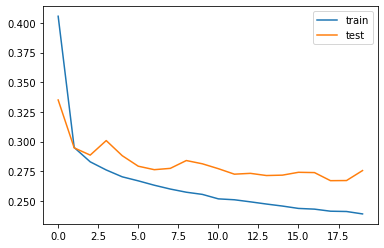

In [37]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

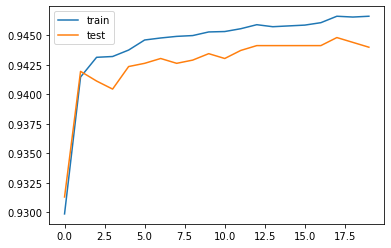

In [38]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [39]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

322050
303180
Error Percentage in predicted values is : 5.859338612016768 %


In [40]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9226000253198838

In [41]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [42]:
acc.append(max(history.history['accuracy']))

# November

In [43]:
working_df = house_data[house_data.Month == 11]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(36170, 34) (36170, 21) (9043, 34) (9043, 21)


In [44]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
3617/3617 [==============================] - 10s 3ms/step - loss: 0.3782 - accuracy: 0.9340 - val_loss: 0.2983 - val_accuracy: 0.9417
Epoch 2/20
3617/3617 [==============================] - 10s 3ms/step - loss: 0.2827 - accuracy: 0.9433 - val_loss: 0.2852 - val_accuracy: 0.9429
Epoch 3/20
3617/3617 [==============================] - 10s 3ms/step - loss: 0.2710 - accuracy: 0.9441 - val_loss: 0.2753 - val_accuracy: 0.9433
Epoch 4/20
3617/3617 [==============================] - 10s 3ms/step - loss: 0.2635 - accuracy: 0.9450 - val_loss: 0.2820 - val_accuracy: 0.9445
Epoch 5/20
3617/3617 [==============================] - 10s 3ms/step - loss: 0.2584 - accuracy: 0.9456 - val_loss: 0.2729 - val_accuracy: 0.9438
Epoch 6/20
3617/3617 [==============================] - 10s 3ms/step - loss: 0.2551 - accuracy: 0.9457 - val_loss: 0.2661 - val_accuracy: 0.9449
Epoch 7/20
3617/3617 [==============================] - 10s 3ms/step - loss: 0.2510 - accuracy: 0.9461 - val_loss: 0.2623 - val_ac

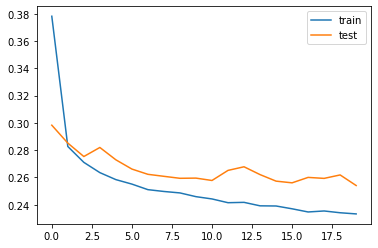

In [45]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

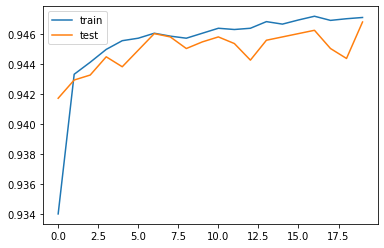

In [46]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [47]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

407205
380880
Error Percentage in predicted values is : 6.464802740634325 %


In [48]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9277236639550959

In [49]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [50]:
acc.append(max(history.history['accuracy']))

# December

In [51]:
working_df = house_data[house_data.Month == 12]

working_df = working_df[['T_ctrl', 'T_stp_heat', 'auxHeat1', 'T_out', 'RH_out']]
cols = ['T_ctrl', 'T_stp_heat', 'T_out', 'RH_out', 'auxHeat1']
working_df = working_df[cols]
cumulative_df = cumulative_df.append(working_df)

reframed = series_to_supervised(cumulative_df, 6, 1)

y_auxHeat = reframed['var5(t)']
y_auxHeat = to_categorical(y_auxHeat)
X = reframed.drop(labels = ["var5(t)"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y_auxHeat, test_size = 0.2, shuffle = True)

X_train = X_train.values
X_test = X_test.values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(43281, 34) (43281, 21) (10821, 34) (10821, 21)


In [52]:
classifier = Sequential()

# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu', input_dim = 34))

# Adding the second hidden layer
classifier.add(Dense(units = 24, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 21, kernel_initializer = 'uniform', activation = 'softmax'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Fitting the ANN to the Training set
history = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 20, shuffle = True)

Epoch 1/20
4329/4329 [==============================] - 14s 3ms/step - loss: 0.3781 - accuracy: 0.9318 - val_loss: 0.2865 - val_accuracy: 0.9426
Epoch 2/20
4329/4329 [==============================] - 13s 3ms/step - loss: 0.2911 - accuracy: 0.9406 - val_loss: 0.2717 - val_accuracy: 0.9443
Epoch 3/20
4329/4329 [==============================] - 13s 3ms/step - loss: 0.2774 - accuracy: 0.9415 - val_loss: 0.2808 - val_accuracy: 0.9425
Epoch 4/20
4329/4329 [==============================] - 13s 3ms/step - loss: 0.2699 - accuracy: 0.9424 - val_loss: 0.2601 - val_accuracy: 0.9452
Epoch 5/20
4329/4329 [==============================] - 13s 3ms/step - loss: 0.2663 - accuracy: 0.9428 - val_loss: 0.2641 - val_accuracy: 0.9448
Epoch 6/20
4329/4329 [==============================] - 13s 3ms/step - loss: 0.2619 - accuracy: 0.9429 - val_loss: 0.2544 - val_accuracy: 0.9467
Epoch 7/20
4329/4329 [==============================] - 13s 3ms/step - loss: 0.2604 - accuracy: 0.9428 - val_loss: 0.2548 - val_ac

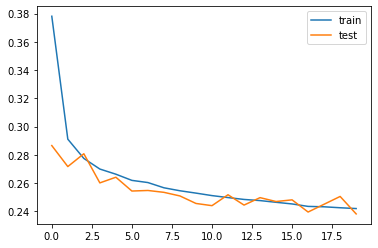

In [53]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

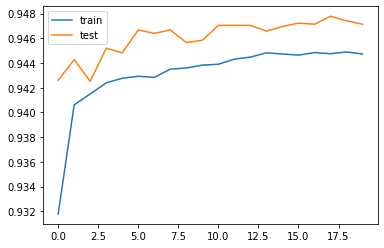

In [54]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'], label = 'test')
plt.legend()
plt.show()

In [55]:
y_predicted = classifier.predict(X_test)

y_predicted = np.argmax(y_predicted, axis = 1)

y_test = np.argmax(y_test, axis = 1)

test_sum = 0
for i in range(len(y_test)):
    test_sum += (y_test[i] * 15)

print(test_sum)

predicted_sum = 0
for i in range(len(y_predicted)):
    predicted_sum += (y_predicted[i] * 15)

print(predicted_sum)

print("Error Percentage in predicted values is : {} %".format(np.absolute((predicted_sum - test_sum)/test_sum)*100))
err.append(np.absolute((predicted_sum - test_sum)/test_sum)*100)

499695
476595
Error Percentage in predicted values is : 4.622819920151292 %


In [56]:
f1_score(y_test, y_predicted, average = 'weighted')

0.9290281656887686

In [57]:
f1.append(f1_score(y_test, y_predicted, average = 'weighted'))

In [58]:
acc.append(max(history.history['accuracy']))

[Text(0, 0.5, 'Weighted F1-Score'), Text(0.5, 0, 'Data Upto & Including')]

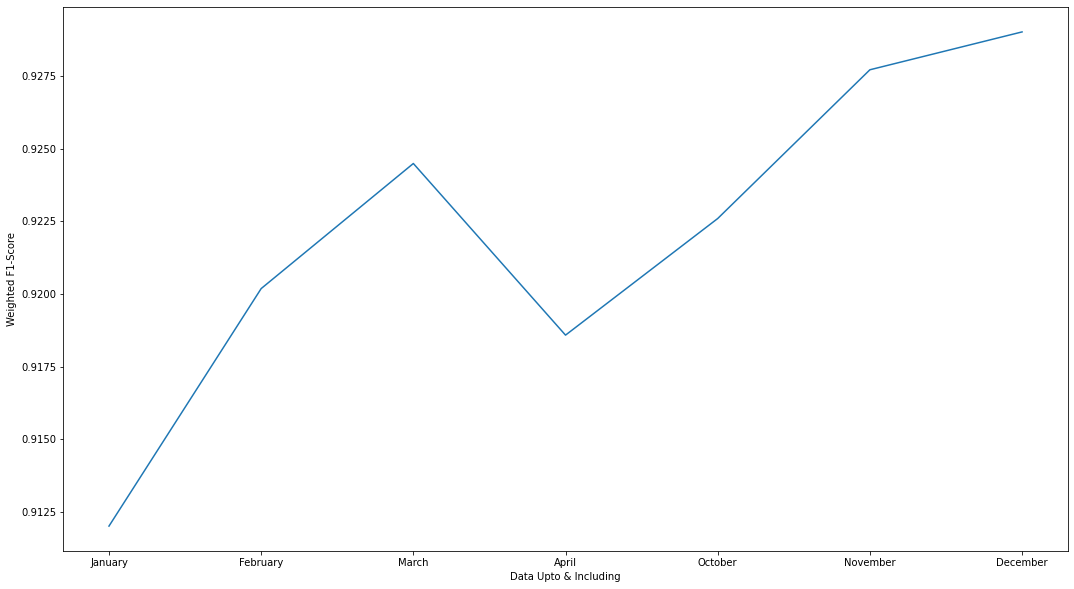

In [59]:
plt.figure(figsize = (18, 10))
ax = sns.lineplot(x = months, y = f1, sort = False)
ax.set(xlabel = "Data Upto & Including", ylabel = "Weighted F1-Score")

[Text(0, 0.5, 'Accuracy'), Text(0.5, 0, 'Data Upto & Including')]

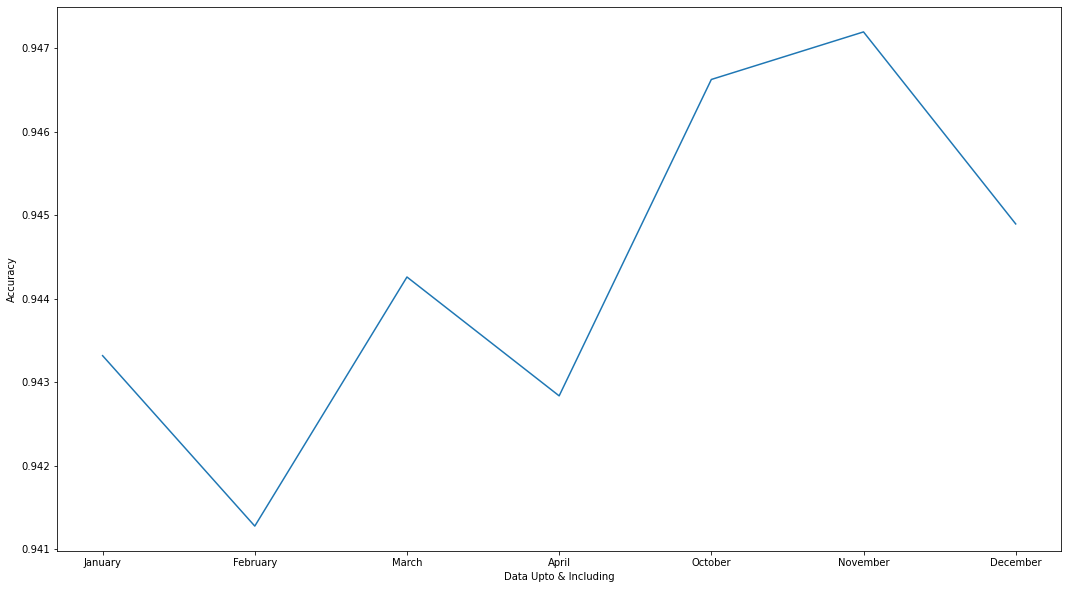

In [60]:
plt.figure(figsize = (18, 10))
ax = sns.lineplot(x = months, y = acc, sort = False)
ax.set(xlabel = "Data Upto & Including", ylabel = "Accuracy")

[Text(0, 0.5, 'Error % in Prediction'), Text(0.5, 0, 'Data Upto & Including')]

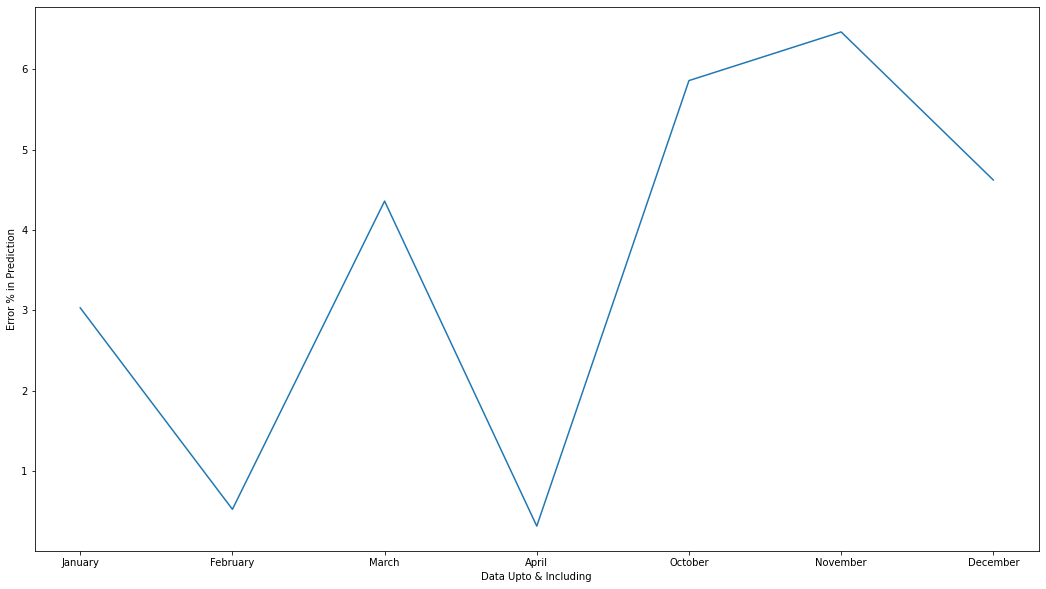

In [61]:
plt.figure(figsize = (18, 10))
ax = sns.lineplot(x = months, y = err, sort = False)
ax.set(xlabel = "Data Upto & Including", ylabel = "Error % in Prediction")